<font size="6"> Economic calculation with a simple example </font>

## Dataset introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load example simulation data
data = pd.read_excel('time_data.xlsx')


In [2]:
# check available collumns in the dataset
data.columns.tolist()


['Unnamed: 0',
 'P16 : BHP (bar)',
 'P16 : p 17 reservoir P (bar)',
 'P16 : p 17 c 1 rate (Kmol/day)',
 'P16 : p 15 reservoir P (bar)',
 'P16 : p 15 c 1 rate (Kmol/day)',
 'P16 : p 15 c 0 rate (Kmol/day)',
 'P16 : p 13 reservoir P (bar)',
 'P16 : p 13 c 1 rate (Kmol/day)',
 'P16 : p 13 c 0 rate (Kmol/day)',
 'P16 : p 12 c 0 rate (Kmol/day)',
 'P16 : p 11 reservoir P (bar)',
 'P16 : p 10 reservoir P (bar)',
 'P16 : p 10 c 1 rate (Kmol/day)',
 'P16 : p 10 c 0 rate (Kmol/day)',
 'P16 : p 9 c 1 rate (Kmol/day)',
 'P16 : p 8 reservoir P (bar)',
 'P16 : p 8 c 1 rate (Kmol/day)',
 'P16 : p 8 c 0 rate (Kmol/day)',
 'P16 : p 7 reservoir P (bar)',
 'P16 : p 7 c 1 rate (Kmol/day)',
 'P16 : p 6 reservoir P (bar)',
 'P16 : p 6 c 1 rate (Kmol/day)',
 'P16 : p 5 c 0 rate (Kmol/day)',
 'P16 : p 4 reservoir P (bar)',
 'P16 : p 4 c 1 rate (Kmol/day)',
 'P16 : p 4 c 0 rate (Kmol/day)',
 'P16 : p 3 reservoir P (bar)',
 'P16 : p 3 c 1 rate (Kmol/day)',
 'P16 : p 3 c 0 rate (Kmol/day)',
 'P16 : p 2 reservoi

In [3]:
# list the collumn names that should be removed
press_gridcells = data.filter(like='reservoir').columns.tolist()
chem_cols = data.filter(like='Kmol').columns.tolist()

wells = ['P11', 'P12', 'P13', 'P14', 'E02', 'E03', 'E04', 'E05']
wells_cols = []
for well in wells:
    well_cols = data.filter(like=well).columns.tolist()
    wells_cols += well_cols

# remove collumns from data
data.drop(columns=press_gridcells + chem_cols + wells_cols, inplace=True)

data.columns.tolist()


['Unnamed: 0',
 'P16 : BHP (bar)',
 'P16 : energy (KJ/day)',
 'P16 : steam rate (m3/day)',
 'P16 : water rate (m3/day)',
 'P15 : BHP (bar)',
 'I01 : energy (KJ/day)',
 'P03 : energy (KJ/day)',
 'time',
 'P16 : temperature (K)',
 'I02 : temperature (K)',
 'I03 : water rate (m3/day)',
 'I02 : BHP (bar)',
 'E01 : energy (KJ/day)',
 'E06 : water rate (m3/day)',
 'FIPS c 0 (kmol)',
 'E01 : steam rate (m3/day)',
 'P02 : water rate (m3/day)',
 'P03 : water rate (m3/day)',
 'E01 : BHP (bar)',
 'I03 : BHP (bar)',
 'I03 : temperature (K)',
 'I03 : steam rate (m3/day)',
 'I01 : temperature (K)',
 'E01 : temperature (K)',
 'P01 : energy (KJ/day)',
 'P01 : water rate (m3/day)',
 'P01 : steam rate (m3/day)',
 'I01 : BHP (bar)',
 'P01 : temperature (K)',
 'P15 : water rate (m3/day)',
 'I01 : water rate (m3/day)',
 'E01 : water rate (m3/day)',
 'P03 : BHP (bar)',
 'P03 : steam rate (m3/day)',
 'I02 : steam rate (m3/day)',
 'P02 : temperature (K)',
 'P02 : BHP (bar)',
 'P03 : temperature (K)',
 'P15 : 

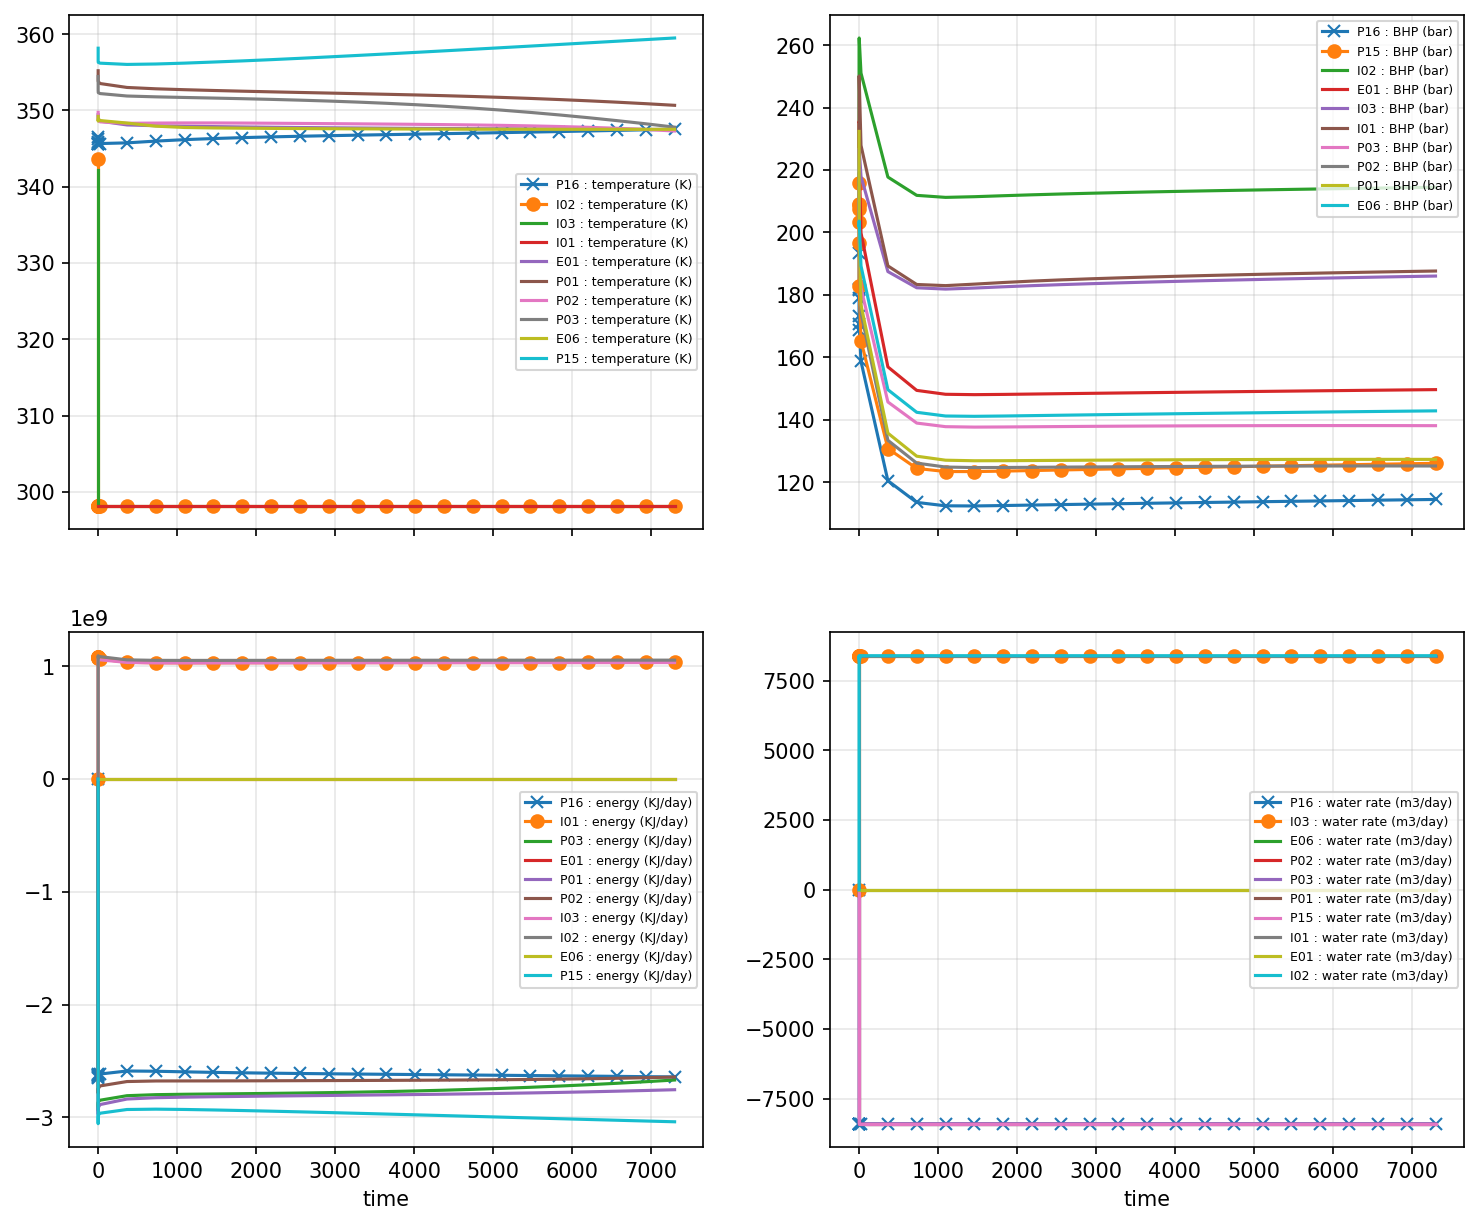

In [4]:
# do a first plot to get an overview of our data
# define a plot
fig, ax = plt.subplots(2,2, figsize=(12,10), dpi=150, sharex=True)
# get plot axes
ax_list = fig.axes

# plot a few keywords in pairs for both wells
for i, key in enumerate(['temperature', 'BHP','energy (KJ/day)','water rate (m3/day)']):
    data.plot(x='time',
              y=data.filter(like=key).columns.tolist(),
              ax=ax_list[i],
              linestyle='-',
              style=['x', 'o'])
    ax_list[i].legend(fontsize=6)
    ax_list[i].grid(alpha=0.3)

plt.show()


## Dataset preparation

In [5]:
# assign datetime as index
data['Datetime'] = pd.to_datetime('1/1/2000') + pd.to_timedelta(data['time'] * pd.Timedelta(('24 hours')), unit='h')
data.set_index('Datetime', inplace=True)

# set the new time interval
set_interval = '24h'


In [6]:
# generate the new index on which the data should correspond based on original index range
resample_index = pd.date_range(data.index[0] - pd.Timedelta(set_interval),
                               data.index[-1] + pd.Timedelta(set_interval), freq=set_interval, normalize=True,
                               closed='right')


In [7]:
# create a new index as the union of the old and new index and interpolate on the combined index
# then reindex the dataframe to the new index
tdata = data.reindex(data.index.union(resample_index)).interpolate('index').reindex(resample_index)

# maintain initial values of original dataset in the newly indexed one at the edges
tdata.iloc[0] = data.iloc[0]
tdata.iloc[-1] = data.iloc[-1]

# add the number of periods for further economic assessment
tdata['econ_periods'] = np.arange(len(tdata))


In [8]:
# compute the deltahours for economic and energy assessments
tdata['Deltahours'] = tdata.index.to_series().diff(1) / pd.Timedelta('1 hour')

# verify that we only have one delta
tdata['Deltahours'].unique()


array([nan, 24.])

In [9]:
# recompute time columns based on index
tdata['Time (yrs)'] = pd.to_timedelta(tdata.index - tdata.index[0]).total_seconds() / (365 * 24 * 60 * 60)

# reset index to time delta
tdata.set_index(pd.to_timedelta(tdata['Time (yrs)'] * pd.Timedelta(('365 days')), unit='s'), inplace=True)
tdata.drop(columns='time', inplace=True)


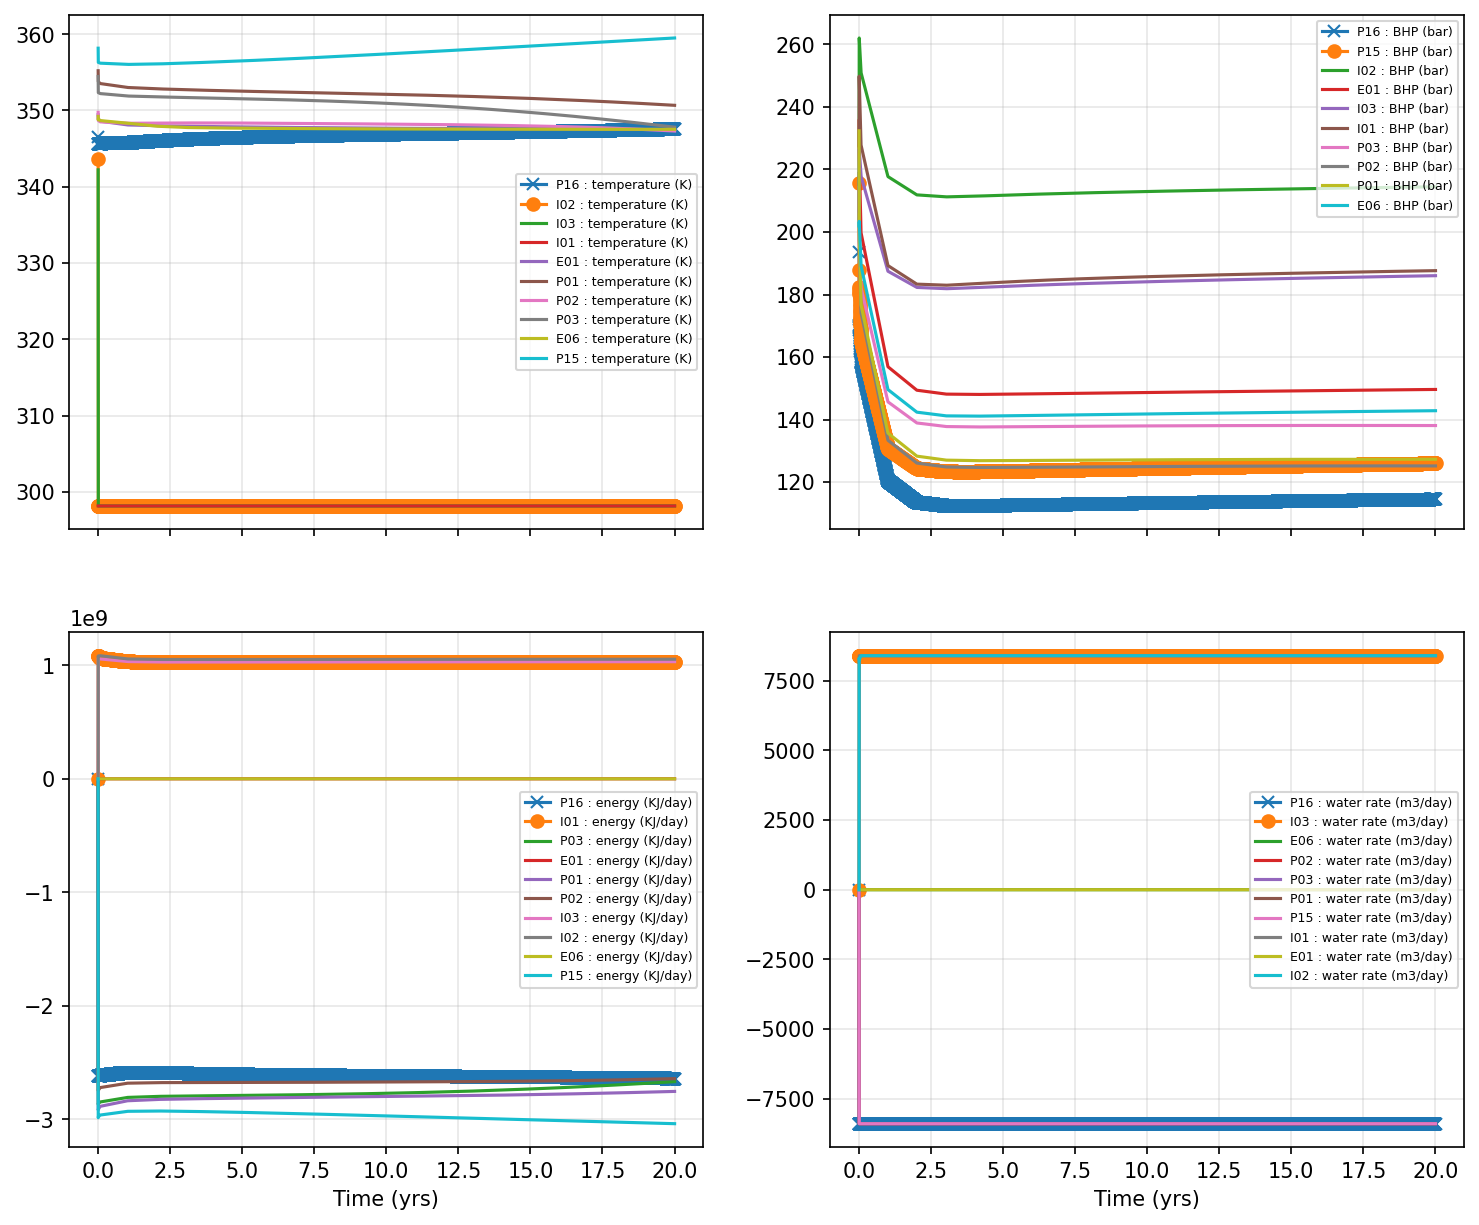

In [10]:
# do a quick plot to get an overview of our treated data
# define a plot
fig, ax = plt.subplots(2,2, figsize=(12,10), dpi=150, sharex=True)
# get plot axes
ax_list = fig.axes

# plot a few keywords in pairs for both wells
for i, key in enumerate(['temperature', 'BHP','energy (KJ/day)','water rate (m3/day)']):
    tdata.plot(x='Time (yrs)',
              y=data.filter(like=key).columns.tolist(),
              ax=ax_list[i],
              linestyle='-',
              style=['x', 'o'])
    ax_list[i].legend(fontsize=6)
    ax_list[i].grid(alpha=0.3)


## Produced energy calculation

In [11]:
# check if the net volume of the produced and injected fluid equal
water_rate = [col for col in tdata.columns if 'water rate' in col]
tdata[water_rate].median().sort_values()


P16 : water rate (m3/day)   -8400.000000
P02 : water rate (m3/day)   -8400.000000
P15 : water rate (m3/day)   -8400.000000
P01 : water rate (m3/day)   -8400.000000
P03 : water rate (m3/day)   -8399.999999
E06 : water rate (m3/day)       0.000000
E01 : water rate (m3/day)       0.000000
I01 : water rate (m3/day)    8400.000000
I03 : water rate (m3/day)    8400.000000
I02 : water rate (m3/day)    8400.000000
dtype: float64

<AxesSubplot:xlabel='Time (yrs)'>

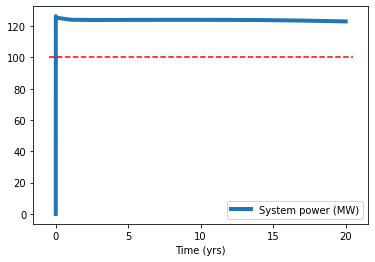

In [12]:
kJ_day_MW = 1/3.6e6/24

# compute system power
tdata['System power (MW)'] = (abs(tdata['P01 : energy (KJ/day)']) -
                              abs(tdata['I01 : energy (KJ/day)']) +
                              abs(tdata['P02 : energy (KJ/day)']) - 
                              abs(tdata['I02 : energy (KJ/day)']) +
                              abs(tdata['P03 : energy (KJ/day)']) -
                              abs(tdata['I03 : energy (KJ/day)']) +
                              abs(tdata['P15 : energy (KJ/day)']) -
                              abs(tdata['E06 : energy (KJ/day)']) +
                              abs(tdata['P16 : energy (KJ/day)']) -
                              abs(tdata['E01 : energy (KJ/day)'])) * kJ_day_MW

# compute produced energy
tdata['Produced Energy (MWh)'] = tdata['System power (MW)'] * tdata['Deltahours']

tdata.plot('Time (yrs)', 'System power (MW)', lw=4)
pd.Series({-0.5: 100, 20.5: 100}).plot.line(linestyle='--', color='r')

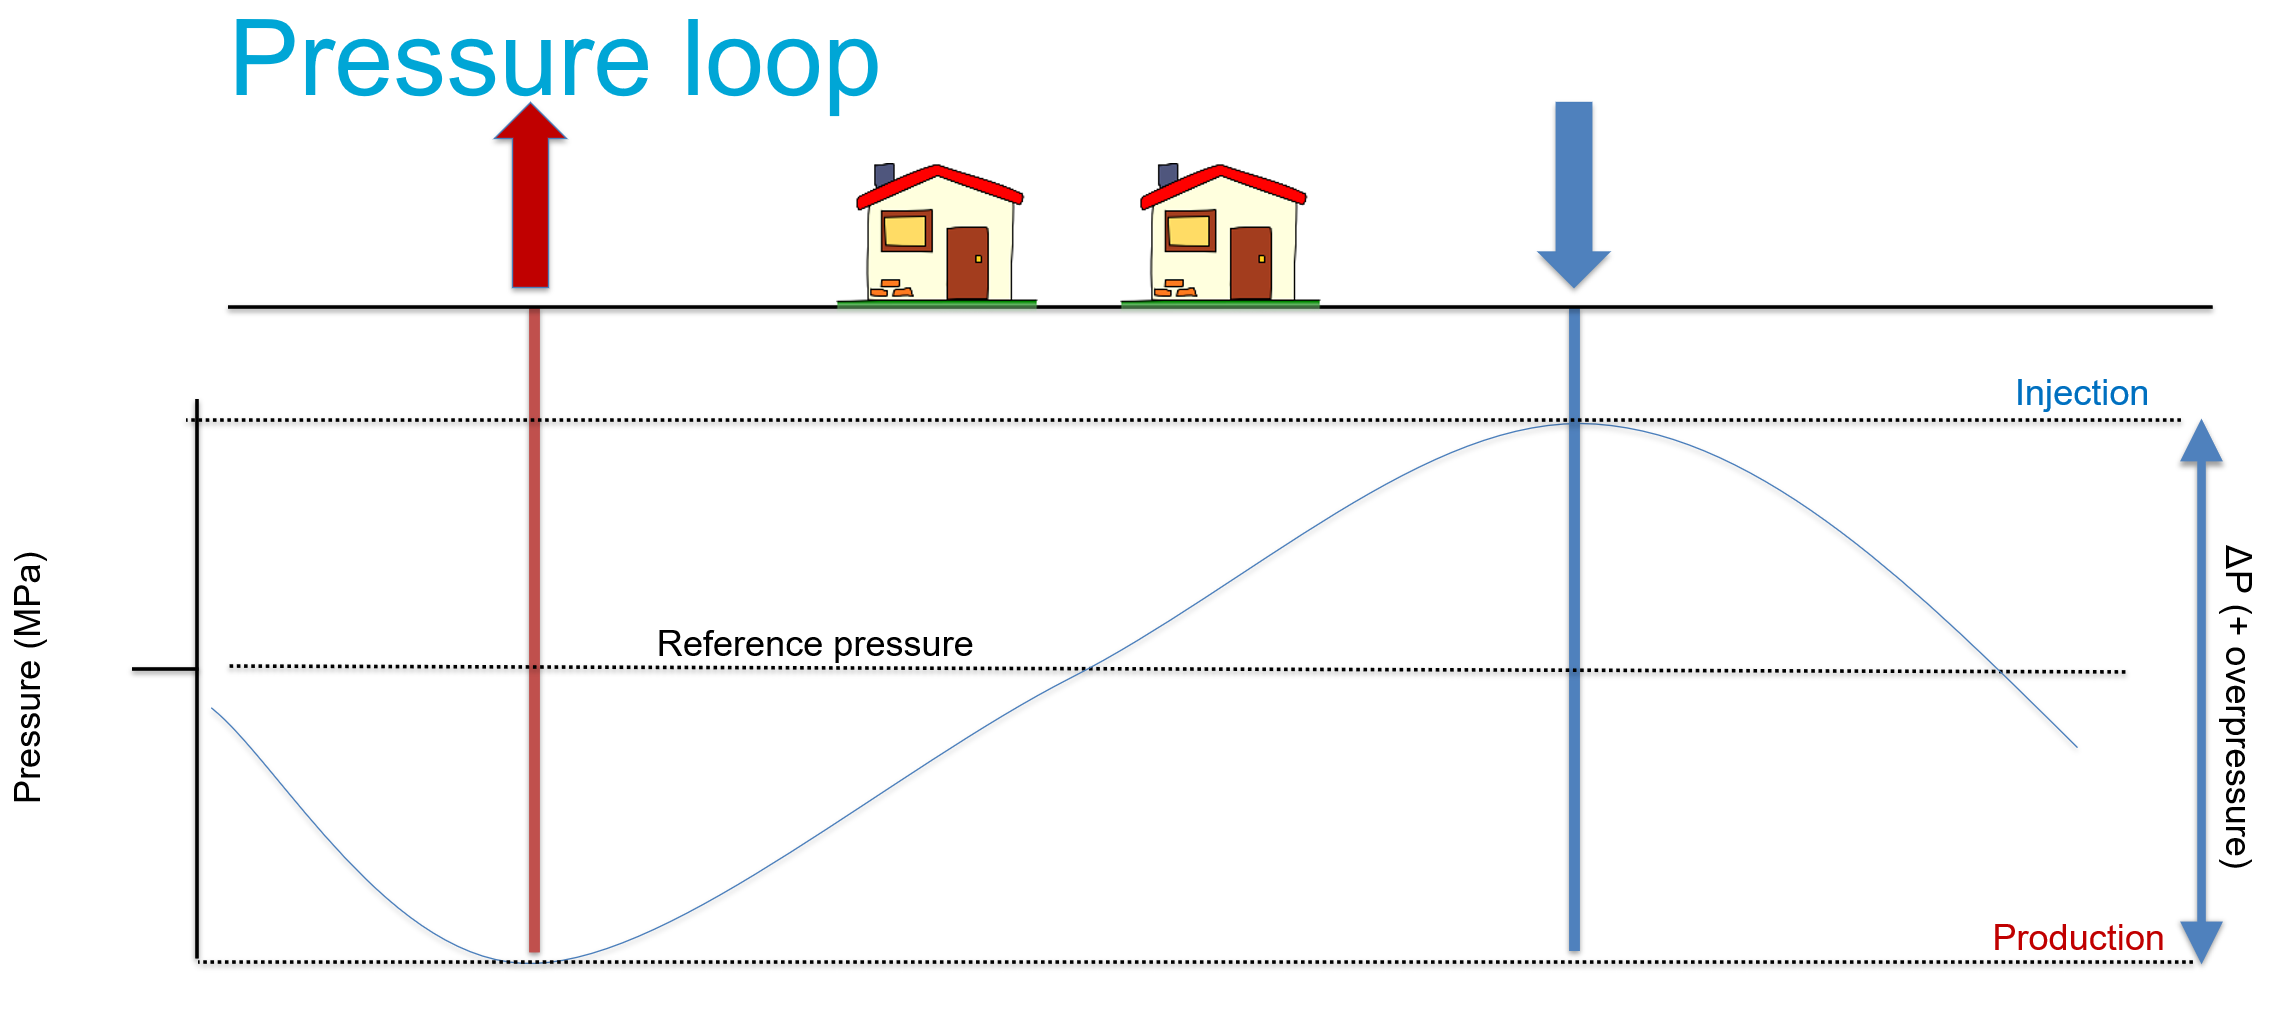


In [13]:
# compute the pressured drop
tdata['Pump dp (MPa)_1'] = abs(tdata['P01 : BHP (bar)'] * 0.1) - abs(tdata['I01 : BHP (bar)'] * 0.1)
tdata['Pump dp (MPa)_2'] = abs(tdata['P02 : BHP (bar)'] * 0.1) - abs(tdata['I02 : BHP (bar)'] * 0.1)
tdata['Pump dp (MPa)_3'] = abs(tdata['P03 : BHP (bar)'] * 0.1) - abs(tdata['I03 : BHP (bar)'] * 0.1)
tdata['Pump dp (MPa)_4'] = abs(tdata['P15 : BHP (bar)'] * 0.1) - abs(tdata['E06 : BHP (bar)'] * 0.1)
tdata['Pump dp (MPa)_5'] = abs(tdata['P16 : BHP (bar)'] * 0.1) - abs(tdata['E01 : BHP (bar)'] * 0.1)


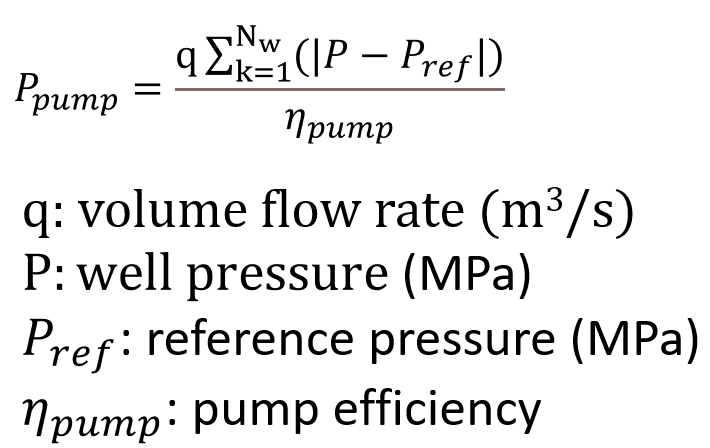

In [14]:
m3_day_m3_sec = 1 / (24 * 60 * 60)
pump_efficiency = 0.5

# compute the pumping power
tdata['Pump power (MW)'] = abs(tdata['I01 : water rate (m3/day)']) * m3_day_m3_sec * \
                           (tdata['Pump dp (MPa)_1'] + tdata['Pump dp (MPa)_2'] +
                            tdata['Pump dp (MPa)_3'] + tdata['Pump dp (MPa)_4'] +
                            tdata['Pump dp (MPa)_5']) / pump_efficiency

# compute the pumping costs
electricity_price = 100 # euro/MWh
tdata['OpEx_pump (\u20ac)'] = tdata['Pump power (MW)'] * tdata['Deltahours'] * electricity_price


In [15]:
# assign the CapEx for drilling the wells
tdata['CapEx (\u20ac)'] = 0
tdata.loc[tdata.index == tdata.index[0], 'CapEx (\u20ac)'] = 72341698

periodic_OpEx_rate = 0.07
# calculate variable OpEx costs
tdata['OpEx (\u20ac)'] = tdata['CapEx (\u20ac)'].cumsum() * periodic_OpEx_rate


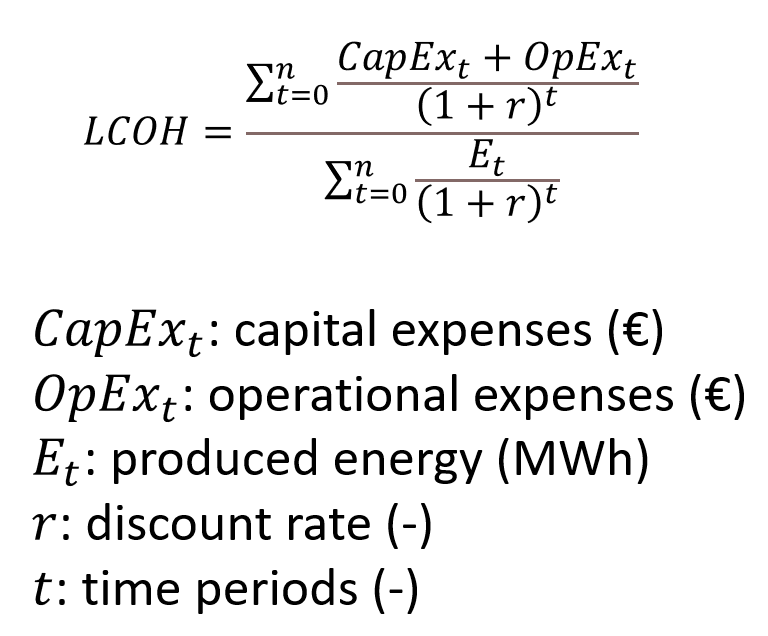

In [16]:
# calculate LCOH
periodic_discount_rate = 0.07

# compute the LCOH costs
tdata['LCOH costs'] = tdata['CapEx (\u20ac)'].fillna(0) \
                        + tdata['OpEx (\u20ac)'] \
                          + tdata['OpEx_pump (\u20ac)'].fillna(0)

# discount LCOH costs
tdata['discounted LCOH costs'] = (tdata['LCOH costs'] /
                                      (1 + periodic_discount_rate) ** tdata['econ_periods']).cumsum()

tdata['discounted LCOH energy'] = (tdata['Produced Energy (MWh)'] /
                                        (1 + periodic_discount_rate) ** tdata[
                                            'econ_periods']).cumsum()

tdata[r'LCOH (€/MWh)'] = tdata['discounted LCOH costs'] / tdata['discounted LCOH energy']

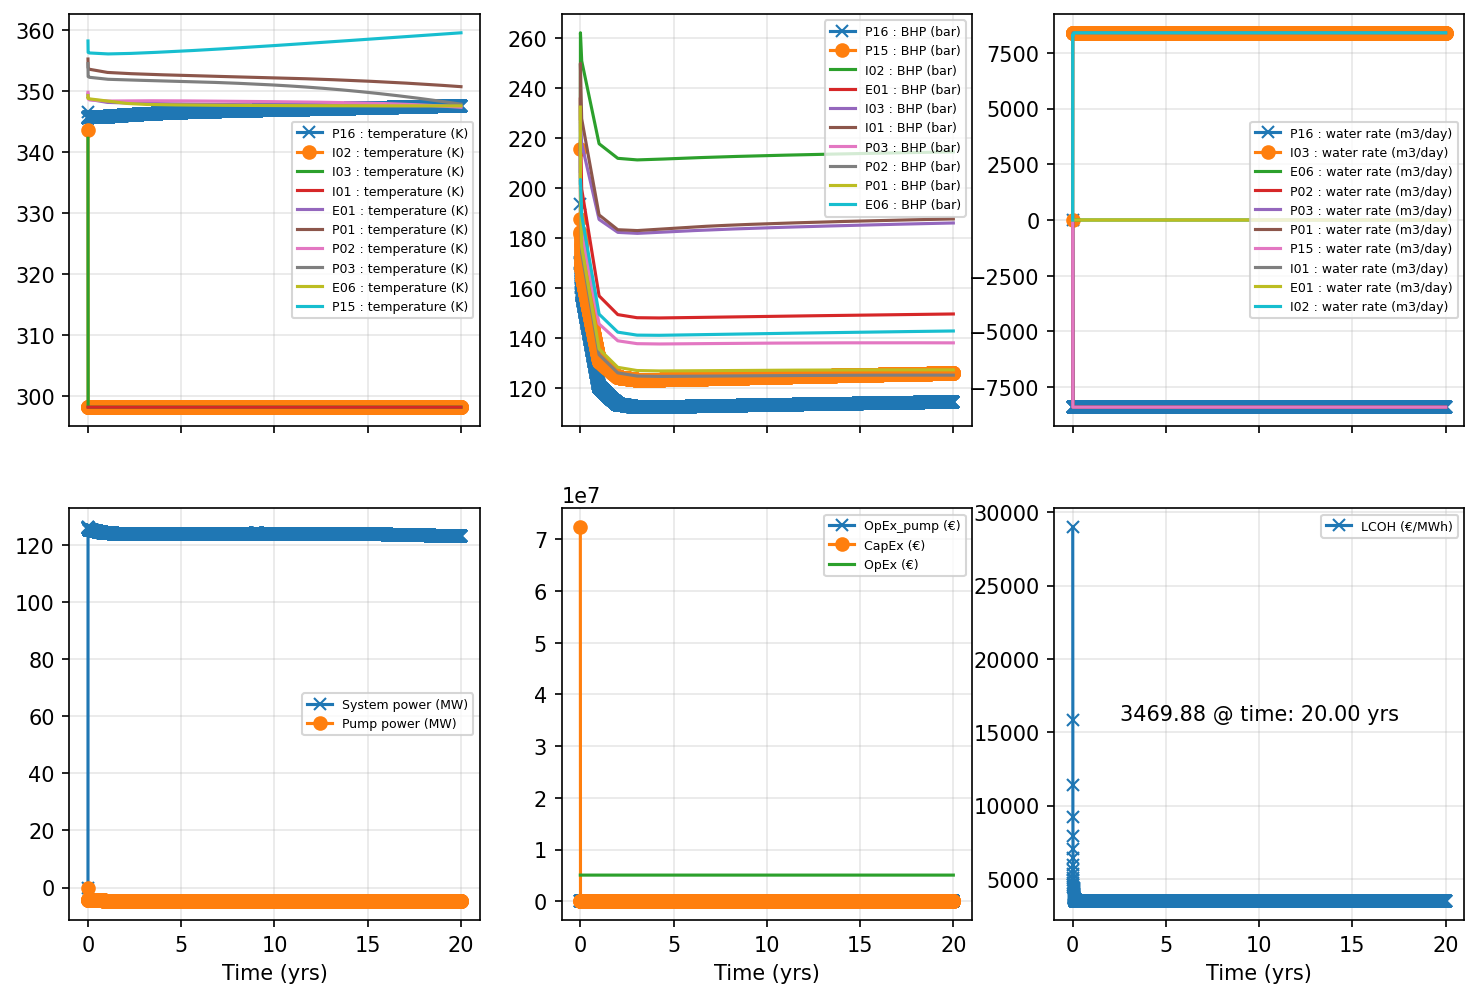

In [17]:
# do our final plot with the overview
# define a plot
fig, ax = plt.subplots(2,3, figsize=(12,8), dpi=150, sharex=True)
# get plot axes
ax_list = fig.axes

# plot a few keywords in pairs for both wells
for i, key in enumerate(['temperature', 'BHP','water rate (m3/day)',
                         'power', 'Ex','LCOH (€/MWh)']):
    tdata.plot(x='Time (yrs)',
              y=tdata.filter(like=key).columns.tolist(),
              ax=ax_list[i],
              linestyle='-',
              style=['x', 'o'])
    ax_list[i].legend(fontsize=6)
    ax_list[i].grid(alpha=0.3)
    if key == 'LCOH (€/MWh)':
        ax_list[i].annotate('%0.2f @ time: %.2f yrs' % (tdata[key].iloc[-1], tdata['Time (yrs)'].iloc[-1]),
                            xy=(0.5, 0.5), va='center', ha='center',
                            xycoords=('axes fraction'))

In [18]:
def drillingcostnl(depth):
    """
    Calculate the cost of drilling as a function of depth
    Reference source:
        https://www.thermogis.nl/en/economic-model

    :param depth: float
        measured depth along hole in meters

    :return: float
        costs in euros
    """
    drilling_cost_nl = 375000 + 1150 * depth + 0.3 * depth ** 2
    return(drilling_cost_nl)


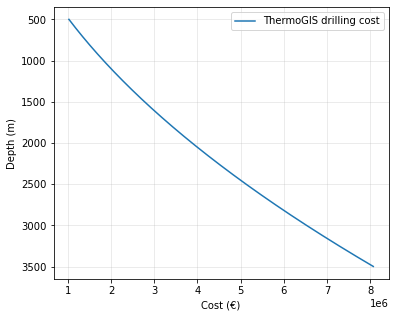

In [19]:
depth = np.arange(500, 3500, 1)

costs = drillingcostnl(depth)

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(costs, depth, label='ThermoGIS drilling cost')
ax.set_xlabel('Cost (€)')
ax.set_ylabel('Depth (m)')
ax.grid(alpha=0.3)
ax.legend()
ax.invert_yaxis()


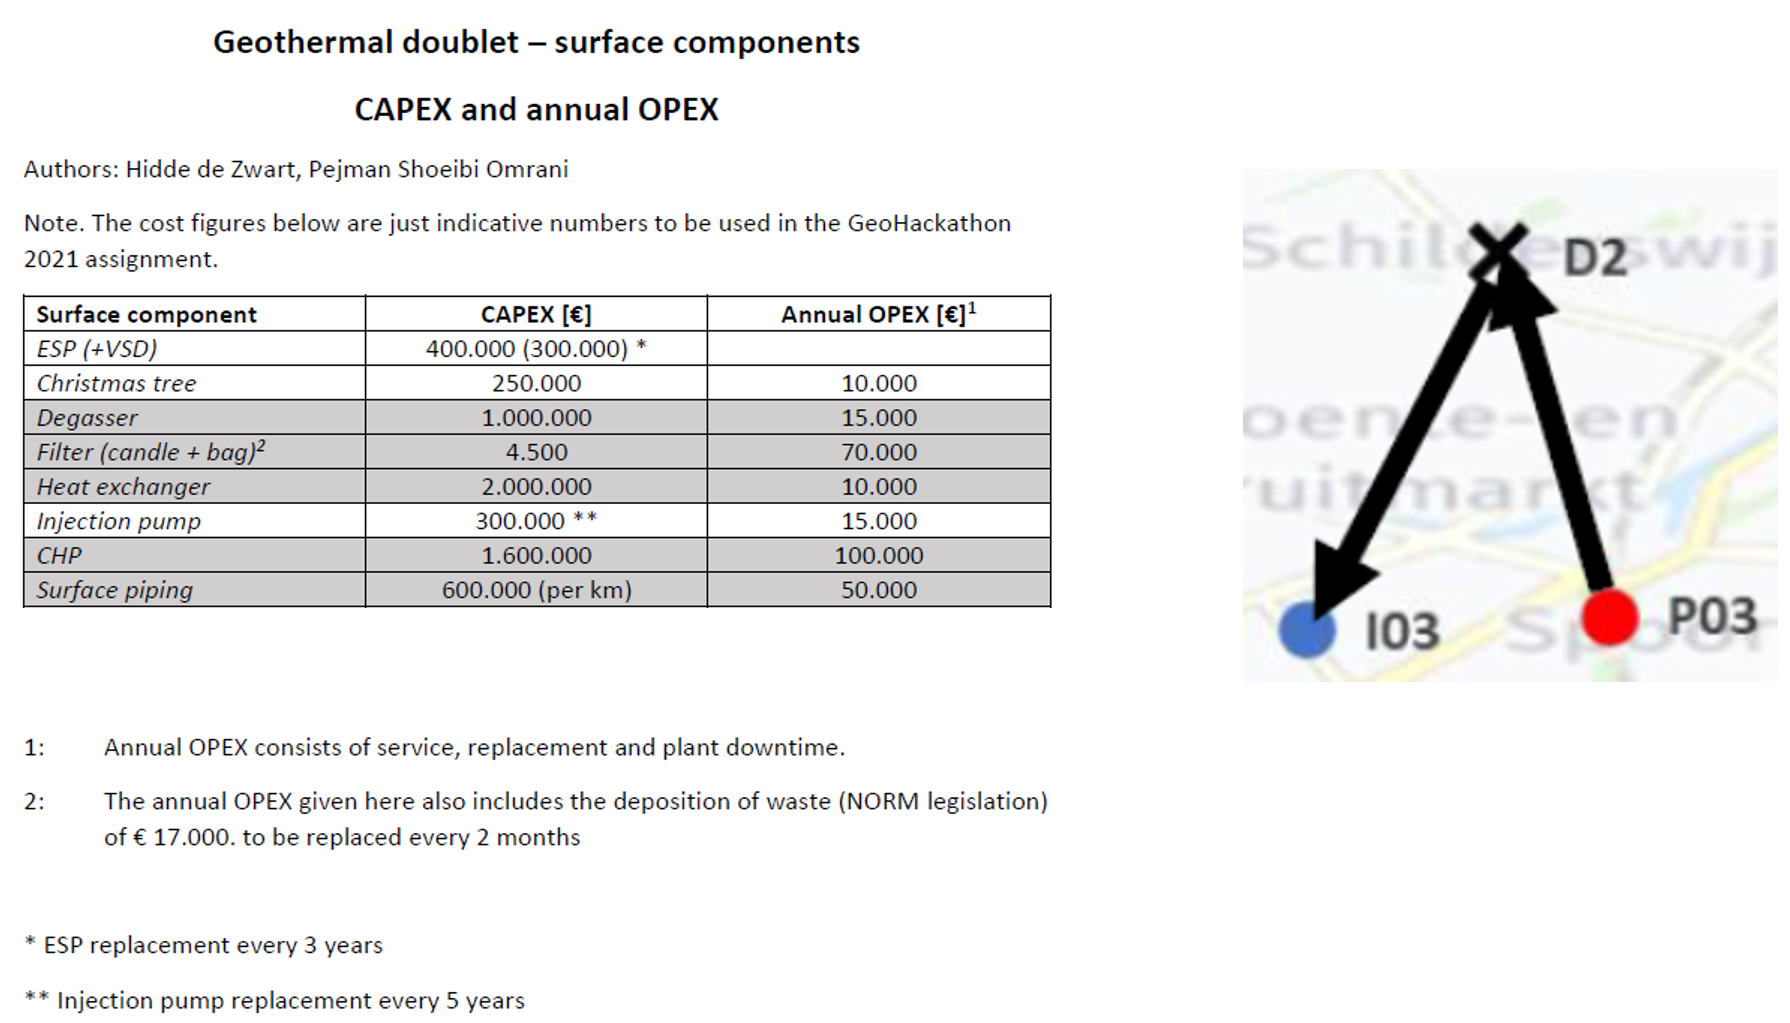